## Импорты библиотек

In [1]:
!pip install optuna catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 7.2 MB/s eta 0:00:00


In [5]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from catboost import CatBoostRegressor

from scipy.stats import zscore

## Загрузка данных и предобработка

In [6]:
def ts_from_csv(csv_path, resampling = "h"):
    df = pd.read_csv(csv_path)
    df['date'] = pd.to_datetime(df['date'])
    df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time
    df['date_time'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str))

    df.set_index('date_time', inplace=True)
    df.drop(columns=['date', 'time'], inplace=True)

    df = df.resample(resampling).sum().fillna(0)
    for col in df.columns:
        df[col] = np.where(zscore(df[col]) > 3, df[col].median(), df[col])

    return df

Класс для формирования фичей (лаги, скользящие средние, временные параметры)

In [7]:
class ForecastPreprocessor:

    def __init__(
        self,
        lag_config: dict[str,list[int]]=None,
        rolling_config: dict[str,list[int]]=None,
    ):
        self.lag_config = lag_config if lag_config else {}
        self.rolling_config = rolling_config if rolling_config else {}

        self.created_features = set()
        self.used_columns = set()
        self._fit = False

    def add_lags(self, df):
        """
        Добавляет лаги к выбранным колонкам.
        """
        df = df.copy()
        for col, lags in self.lag_config.items():
            if col not in df.columns:
                continue
            for lag in lags:
                new_col = f'{col}_lag{lag}'
                df[new_col] = df[col].shift(lag)
                self.created_features.add(new_col)
                self.used_columns.add(new_col)
        return df

    def add_rolling(self, df):
        """
        Добавляет скользящие средние к выбранным колонкам.
        """
        df = df.copy()
        for col, windows in self.rolling_config.items():
            if col not in df.columns:
                continue
            for window in windows:
                new_col = f'{col}_roll{window}'
                df[new_col] = df[col].shift().rolling(window=window, min_periods=1).mean()
                self.created_features.add(new_col)
                self.used_columns.add(new_col)
        return df

    def add_time_features(self, df):
        """
        Добавляет временные признаки к датафрейму на основе индекса.
        """
        if not isinstance(df.index, pd.DatetimeIndex):
            raise TypeError("Индекс датафрейма должен быть типа DatetimeIndex")

        # Создаем копию, чтобы не менять исходный датафрейм
        new_df = df.copy()


        # Базовые временные компоненты
        new_df[f'year'] = df.index.year
        new_df[f'month'] = df.index.month
        new_df[f'day'] = df.index.day
        new_df[f'dayofweek'] = df.index.dayofweek
        new_df[f'quarter'] = df.index.quarter
        # new_df[f'{pref}dayofyear'] = df.index.dayofyear

        # Добавляем номер недели в году
        # new_df[f'{pref}weekofyear'] = df.index.isocalendar().week

        # Временные компоненты (если в данных есть время)
        has_time = (df.index.hour > 0).any() or (df.index.minute > 0).any()
        if has_time:
            new_df[f'hour'] = df.index.hour

        # Флаги
        new_df[f'is_weekend'] = df.index.dayofweek.isin([5, 6]).astype(int)

        self.time_features = (set(new_df.columns) - set(df.columns))
        self.used_columns.update(self.time_features)
        return new_df


    def drop_unused_columns(self, df, keep_originals=True):
        """
        Удаляет колонки, которые не были задействованы в процессе создания признаков.
        """
        df = df.copy()
        originals = set(self.lag_config.keys()) | set(self.rolling_config.keys())
        if keep_originals:
            keep_cols = self.used_columns | originals
        else:
            keep_cols = self.used_columns
        drop_cols = set(df.columns) - keep_cols
        df = df.drop(columns=list(drop_cols))
        return df

    def fit_transform(self, df, keep_originals=True):
        """
        Выполняет полный цикл преобразований.
        """
        self.created_features = set()
        self.used_columns = set()
        df = self.add_lags(df)
        df = self.add_rolling(df)
        df = self.add_time_features(df)
        df = self.drop_unused_columns(df, keep_originals=keep_originals)
        self._fit = True
        return df

    def transform(self, df, keep_originals=True):
        """
        Применяет сохранённую конфигурацию к новым данным.
        """
        if not self._fit:
            raise RuntimeError("Сначала вызовите fit_transform на обучающей выборке!")
        return self.fit_transform(df, keep_originals=keep_originals)


## Обучение моделей

Реализовал класс для обучения и подбора гиперпараметров через optuna. Класс универсальный, не ориентирован под определенную модель. Результаты обучения (метрики и параметры) сохранютя в json

In [47]:
from typing import Callable
from sklearn.base import BaseEstimator
from sklearn.feature_selection import RFE
import joblib

class SklearnTrainer:
    def __init__(
        self,
        df ,
        target,
        preprocessor,
        test_size = 0.2,
    ):
        assert target in df, "Отсутсвует таргетная переменная в данных"
        self.df = df
        self.target = target
        self.preprocessor = preprocessor
        self.test_size = test_size

        self.model_dict = {}
        self.model_feature = {}

        self.best_params = {}
        self.eval_metrics = {
            "MAE" : {},
            "RMSE" : {},
        }


    def prepare_data(
        self,
        df : pd.DataFrame
    ) -> tuple[pd.DataFrame, pd.DataFrame]:

        df = df.copy()
        df = self.preprocessor.fit_transform(df)
        df = df.dropna()
        return df.drop(columns=self.target), df[self.target]

    def split_data(
        self,
        X,
        Y
    ):
        return train_test_split(X, Y, test_size=self.test_size, shuffle=False)

    def optim_model(
        self,
        model_name: str,
        model: BaseEstimator,
        trail_params: Callable,
        n_trials=50,
        n_jobs=5
    ):
        X, Y = self.prepare_data(self.df)
        X_train, X_test, Y_train, Y_test = self.split_data(X, Y)
        rfe =RFE(
            model(),
            n_features_to_select=15,
              )
        rfe.fit(X_train,Y_train)
        self.model_feature[model_name] = rfe.get_feature_names_out().tolist()
        X_train = X_train[self.model_feature[model_name]]
        def objective(trial):
            # Определение пространства поиска гиперпараметров
            params = trail_params(trial)

            # Создание и обучение модели с предложенными параметрами
            estimator = model(**params)
            tscv = TimeSeriesSplit(n_splits=5)

            # Выполняем кросс-валидацию с сохранением временной структуры
            rmse_scores = []
            for train_idx, test_idx in tscv.split(X_train):
                X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
                y_fold_train, y_fold_val = Y_train.iloc[train_idx], Y_train.iloc[test_idx]

                estimator.fit(X_fold_train, y_fold_train)
                predictions = estimator.predict(X_fold_val)
                rmse = np.sqrt(mean_squared_error(y_fold_val, predictions))
                rmse_scores.append(rmse)

            # Возвращаем среднее значение RMSE по всем фолдам
            return np.mean(rmse_scores)

        # Создание study для минимизации целевой метрики
        study = optuna.create_study(direction='minimize')
        study.optimize(
            objective,
            n_trials=n_trials,
            n_jobs=n_jobs
        )

        print(f"Лучшие параметры для {model_name}: {study.best_params}")
        print(f"Лучший RMSE: {study.best_value:.4f}")
        best_model = model(**study.best_params).fit(X_train,Y_train)
        self.model_dict[model_name] = best_model
        self.best_params[model_name] = study.best_params

        return study

    def get_model(
        self,
        model_name
    )->BaseEstimator:
        assert model_name in self.model_dict, f"Модель {model_name} не оптимизировалась"
        return self.model_dict[model_name]

    def recursive_forecast(
            self,
            model,
            initial_data,
            selected_features,
            steps,
            time_delta
    ):
        current_data = initial_data.copy()
        forecasts = []

        for _ in range(steps):
            # Создаем копию данных для текущей итерации
            temp_df = current_data.copy()
            new_index = temp_df.index[-1] + time_delta
            new_row = {self.target: 0}
            temp_df.loc[new_index] = new_row

            # Создание фичей
            df, _ = self.prepare_data(temp_df)
            df = df[selected_features]
            # Получаем последнюю строку для прогноза
            features = df.iloc[[-1]]

            # Прогнозируем
            pred = model.predict(features)[0]
            forecasts.append(pred )

            # Обновляем данные
            new_row = {self.target: pred}
            current_data.loc[new_index] = new_row

        return np.array(forecasts)

    def forecast_eval(
            self,
            model_name,
            horizon
    ):
        X, Y = self.prepare_data(self.df)
        X_train, X_test, Y_train, Y_test = self.split_data(X, Y)

        model = self.get_model(model_name)

        time_delta = self.df.index[1] - self.df.index[0]
        start_date = Y_test.index[0]
        last_date = self.df.index[-1]
        metrics = {
            "model" : model_name
        }
        results = []

        cur_date = start_date
        preds = []
        targets = []
        while (cur_date + (horizon+1) * time_delta <= last_date):
            preds.append(
                self.recursive_forecast(
                    model,
                    self.df.loc[:cur_date-time_delta],
                    self.model_feature[model_name],
                    horizon,
                    time_delta
                )
            )
            targets.append(
                self.df.loc[cur_date:cur_date + (horizon-1)*time_delta, self.target].values.reshape(-1,)
            )
            cur_date = cur_date + time_delta

        # print(preds)
        y_pred = np.vstack(preds, )
        y_true = np.vstack(targets,)
        # print(preds[0])
        # print(targets[0])


        mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values').tolist()
        rmse = np.sqrt(mean_squared_error(y_true, y_pred,multioutput='raw_values')).tolist()
        self.eval_metrics["MAE"][model_name] = mae
        self.eval_metrics["RMSE"][model_name] = rmse
        return{
            "mae": mae,
            "rmse" : rmse
        }

        self.eval_metrics.append(metrics)
        return {model_name: results}

    def eval(
        self,
        horizons: list[int]
    ):
        for model_name in self.model_dict:
            self.forecast_eval(model_name, horizons)


        plt.figure(figsize=(10, 5))
        for model, mae in self.eval_metrics["MAE"].items():
            plt.plot(mae, label=model)
        plt.legend()
        plt.title('MAE')
        plt.xlabel('Horizon')
        plt.ylabel('Value')
        plt.show()

        plt.figure(figsize=(10, 5))
        for model, rmse in self.eval_metrics["RMSE"].items():
            plt.plot(rmse, label=model)
        plt.legend()
        plt.title('RMSE')
        plt.xlabel('Horizon')
        plt.ylabel('Value')
        plt.show()


    def save_results(self, dir: str):
        os.makedirs(dir, exist_ok=True)
        params_path = os.path.join(dir,"best_params.json")
        metrics_path = os.path.join(dir,"eval_metrics.json")
        feature_path = os.path.join(dir,"features.json")


        with open(params_path, "w", encoding="utf8") as param, \
            open(metrics_path, "w", encoding="utf8") as metric, \
            open(feature_path, "w", encoding="utf8") as feature :
            json.dump(self.best_params, param, indent=4)
            json.dump(self.eval_metrics, metric, indent=4)
            json.dump(self.model_feature, feature, indent=4)

        for model_name, model in self.model_dict.items():
            joblib.dump(model, os.path.join(dir,f"{model_name}.pkl"))


In [48]:
def lr_params(trial):
    params = {
        'random_state':  trial.suggest_categorical('random_state',[42]),
        'alpha': trial.suggest_float('alpha', 0.05, 1.),
    }
    return params

def rf_params(trial):
    params = {
        'random_state':  trial.suggest_categorical('random_state',[42]),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 50, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
    }
    return params

def gb_params(trial):
    params = {
        'random_state':  trial.suggest_categorical('random_state',[42]),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
    }
    return params

def cb_params(trial):
    params = {
        'random_seed':  trial.suggest_categorical('random_seed',[42]),
        'verbose': trial.suggest_categorical('verbose', [False]),
        'allow_writing_files':  trial.suggest_categorical('allow_writing_files', [False]),
        'iterations': trial.suggest_int('iterations', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'depth': trial.suggest_int('depth', 3, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 30),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10.0),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
    }
    return params


### Отгрузки по дням

In [49]:
df = ts_from_csv("outcoming.csv", "D")
target_column = "outgoing_volume"
df[target_column]/=df[target_column].max()

In [50]:
proc = ForecastPreprocessor(
    lag_config={
        target_column : range(1,15)
    },
    rolling_config={
        target_column : [2,7,14,30]
    }
)

In [51]:
trainer = SklearnTrainer(
    df=df,
    target=target_column,
    preprocessor=proc,
    test_size=0.2
)

In [52]:
trainer.optim_model(
    "Lasso",
    Lasso,
    lr_params,
    n_trials=100
)

[I 2025-05-21 10:03:44,532] A new study created in memory with name: no-name-feacebcc-f5dc-48da-a28e-4b4e2d8dcd38
[I 2025-05-21 10:03:44,603] Trial 1 finished with value: 0.16082008521817692 and parameters: {'random_state': 42, 'alpha': 0.2021380037730281}. Best is trial 1 with value: 0.16082008521817692.
[I 2025-05-21 10:03:44,697] Trial 0 finished with value: 0.15841891705067992 and parameters: {'random_state': 42, 'alpha': 0.07076163695849703}. Best is trial 0 with value: 0.15841891705067992.
[I 2025-05-21 10:03:44,728] Trial 5 finished with value: 0.16082008521817692 and parameters: {'random_state': 42, 'alpha': 0.8756941923905655}. Best is trial 0 with value: 0.15841891705067992.
[I 2025-05-21 10:03:44,735] Trial 3 finished with value: 0.16082008521817692 and parameters: {'random_state': 42, 'alpha': 0.9782468562366412}. Best is trial 0 with value: 0.15841891705067992.
[I 2025-05-21 10:03:44,762] Trial 2 finished with value: 0.16082008521817692 and parameters: {'random_state': 42,

Лучшие параметры для Lasso: {'random_state': 42, 'alpha': 0.05925176934732091}
Лучший RMSE: 0.1582


In [53]:
trainer.optim_model(
    "RandomForest",
    RandomForestRegressor,
    rf_params,
    n_trials=100
)

[I 2025-05-21 10:03:56,452] A new study created in memory with name: no-name-a41f7a0b-b492-4f34-846e-03570a571830
[I 2025-05-21 10:04:00,443] Trial 1 finished with value: 0.12387469717363057 and parameters: {'random_state': 42, 'n_estimators': 67, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.12387469717363057.
[I 2025-05-21 10:04:03,226] Trial 2 finished with value: 0.12582339257546654 and parameters: {'random_state': 42, 'n_estimators': 130, 'max_depth': 24, 'min_samples_split': 11, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.12387469717363057.
[I 2025-05-21 10:04:11,217] Trial 5 finished with value: 0.1254297718647948 and parameters: {'random_state': 42, 'n_estimators': 200, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.12387469717363057.
[I 2025-05-21 10:04:13,559] Trial 4 finished with value: 0.12181128991760048 and parameters: {'random_state': 42, 'n_estimators': 230, 'max

Лучшие параметры для RandomForest: {'random_state': 42, 'n_estimators': 297, 'max_depth': 49, 'min_samples_split': 2, 'min_samples_leaf': 1}
Лучший RMSE: 0.1214


In [54]:
trainer.optim_model(
    "GradientBoosting",
    GradientBoostingRegressor,
    gb_params,
    n_trials=100
)

[I 2025-05-21 10:10:45,026] A new study created in memory with name: no-name-30cb5eb8-fc8f-4c9c-a20c-7788c0ad9286
[I 2025-05-21 10:10:50,100] Trial 1 finished with value: 0.1362538791662014 and parameters: {'random_state': 42, 'n_estimators': 105, 'learning_rate': 0.09372438883445995, 'max_depth': 18, 'min_samples_split': 18, 'min_samples_leaf': 9, 'subsample': 0.9448845559281469}. Best is trial 1 with value: 0.1362538791662014.
[I 2025-05-21 10:10:53,740] Trial 0 finished with value: 0.13148462299507677 and parameters: {'random_state': 42, 'n_estimators': 210, 'learning_rate': 0.07730820059760284, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 6, 'subsample': 0.7602586284436901}. Best is trial 0 with value: 0.13148462299507677.
[I 2025-05-21 10:11:01,196] Trial 4 finished with value: 0.1253318976504124 and parameters: {'random_state': 42, 'n_estimators': 286, 'learning_rate': 0.009659599308005317, 'max_depth': 17, 'min_samples_split': 17, 'min_samples_leaf': 3, 'subsample

Лучшие параметры для GradientBoosting: {'random_state': 42, 'n_estimators': 358, 'learning_rate': 0.00868500229640623, 'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 1, 'subsample': 0.6442254225618304}
Лучший RMSE: 0.1212


In [55]:
trainer.optim_model(
    "CatBoost",
    CatBoostRegressor,
    cb_params,
    n_trials=100
)

Выходные данные были обрезаны до нескольких последних строк (5000).
987:	learn: 0.0090708	total: 6.05s	remaining: 73.5ms
988:	learn: 0.0090471	total: 6.05s	remaining: 67.3ms
989:	learn: 0.0090119	total: 6.06s	remaining: 61.2ms
990:	learn: 0.0089882	total: 6.06s	remaining: 55ms
991:	learn: 0.0089808	total: 6.06s	remaining: 48.9ms
992:	learn: 0.0089513	total: 6.07s	remaining: 42.8ms
993:	learn: 0.0089272	total: 6.07s	remaining: 36.7ms
994:	learn: 0.0089206	total: 6.08s	remaining: 30.5ms
995:	learn: 0.0088990	total: 6.08s	remaining: 24.4ms
996:	learn: 0.0088745	total: 6.08s	remaining: 18.3ms
997:	learn: 0.0088420	total: 6.09s	remaining: 12.2ms
998:	learn: 0.0088144	total: 6.09s	remaining: 6.1ms
999:	learn: 0.0088055	total: 6.1s	remaining: 0us
Learning rate set to 0.03484
0:	learn: 0.1537433	total: 4.11ms	remaining: 4.1s
1:	learn: 0.1513733	total: 13ms	remaining: 6.49s
2:	learn: 0.1492193	total: 22.1ms	remaining: 7.33s
3:	learn: 0.1474220	total: 26ms	remaining: 6.46s
4:	learn: 0.1457783	to

[I 2025-05-21 10:16:52,088] A new study created in memory with name: no-name-1e10685c-21b9-469b-8f50-6a5630e8aba6


982:	learn: 0.0103650	total: 3.19s	remaining: 55.1ms
983:	learn: 0.0103342	total: 3.19s	remaining: 51.9ms
984:	learn: 0.0103276	total: 3.2s	remaining: 48.7ms
985:	learn: 0.0102986	total: 3.2s	remaining: 45.4ms
986:	learn: 0.0102696	total: 3.2s	remaining: 42.2ms
987:	learn: 0.0102525	total: 3.21s	remaining: 39ms
988:	learn: 0.0102433	total: 3.21s	remaining: 35.7ms
989:	learn: 0.0102316	total: 3.21s	remaining: 32.5ms
990:	learn: 0.0102173	total: 3.21s	remaining: 29.2ms
991:	learn: 0.0101968	total: 3.22s	remaining: 26ms
992:	learn: 0.0101587	total: 3.22s	remaining: 22.7ms
993:	learn: 0.0101343	total: 3.22s	remaining: 19.5ms
994:	learn: 0.0101273	total: 3.23s	remaining: 16.2ms
995:	learn: 0.0101129	total: 3.23s	remaining: 13ms
996:	learn: 0.0100870	total: 3.23s	remaining: 9.73ms
997:	learn: 0.0100469	total: 3.24s	remaining: 6.49ms
998:	learn: 0.0100102	total: 3.24s	remaining: 3.24ms
999:	learn: 0.0099789	total: 3.24s	remaining: 0us


[I 2025-05-21 10:16:53,866] Trial 0 finished with value: 0.14919677975450746 and parameters: {'random_seed': 42, 'verbose': False, 'allow_writing_files': False, 'iterations': 74, 'learning_rate': 0.00955905136575272, 'depth': 4, 'min_data_in_leaf': 9, 'l2_leaf_reg': 7.735814939789501, 'random_strength': 4.5003588919593644, 'bagging_temperature': 9.818990227189794, 'border_count': 90, 'subsample': 0.7303280509171304}. Best is trial 0 with value: 0.14919677975450746.
[I 2025-05-21 10:17:03,417] Trial 1 finished with value: 0.13840457030061296 and parameters: {'random_seed': 42, 'verbose': False, 'allow_writing_files': False, 'iterations': 64, 'learning_rate': 0.03441891022317054, 'depth': 8, 'min_data_in_leaf': 6, 'l2_leaf_reg': 2.090622115073954, 'random_strength': 8.977114598717417, 'bagging_temperature': 5.222836377939185, 'border_count': 181, 'subsample': 0.6929517804657638}. Best is trial 1 with value: 0.13840457030061296.
[I 2025-05-21 10:17:08,486] Trial 3 finished with value: 0.1

Лучшие параметры для CatBoost: {'random_seed': 42, 'verbose': False, 'allow_writing_files': False, 'iterations': 239, 'learning_rate': 0.070708946072715, 'depth': 3, 'min_data_in_leaf': 27, 'l2_leaf_reg': 9.231963071121292, 'random_strength': 8.232962174138706, 'bagging_temperature': 7.978228203963208, 'border_count': 207, 'subsample': 0.7938709850417092}
Лучший RMSE: 0.1234


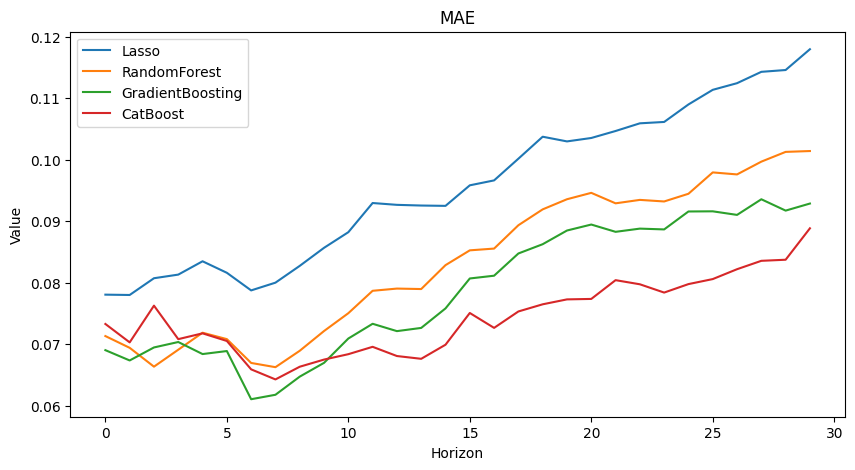

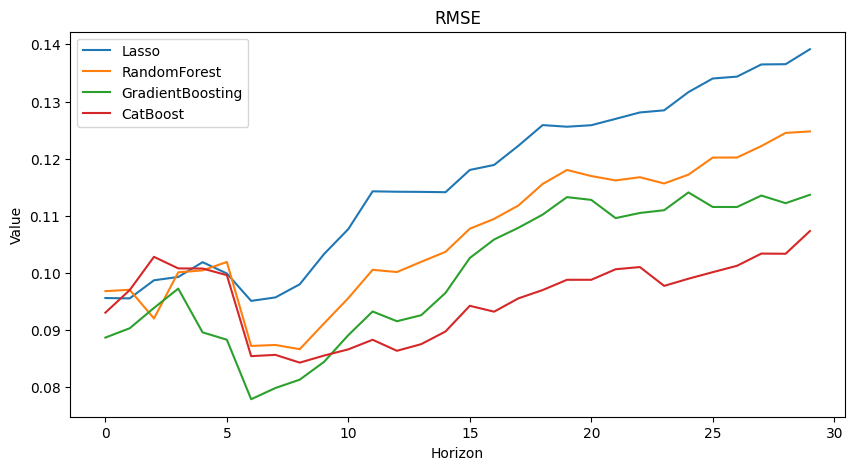

In [56]:
trainer.eval(
    horizons=30
)

In [57]:
trainer.save_results("out_day")

### Приемки по дням

In [59]:
df = ts_from_csv("incoming.csv", "D")
target_column = "incoming_volume"
df[target_column]/=df[target_column].max()

proc = ForecastPreprocessor(
    lag_config={
        target_column : range(1,15)
    },
    rolling_config={
        target_column : [2,7,14,30]
    }
)

trainer = SklearnTrainer(
    df=df,
    target=target_column,
    preprocessor=proc,
    test_size=0.2
)

In [60]:
trainer.optim_model(
    "Lasso",
    Lasso,
    lr_params,
    n_trials=100
)

[I 2025-05-21 10:43:39,693] A new study created in memory with name: no-name-bf33143d-e532-4410-9ef9-3612c23d22b6
[I 2025-05-21 10:43:39,842] Trial 0 finished with value: 0.1504516653307187 and parameters: {'random_state': 42, 'alpha': 0.863344100390859}. Best is trial 0 with value: 0.1504516653307187.
[I 2025-05-21 10:43:39,859] Trial 1 finished with value: 0.1504516653307187 and parameters: {'random_state': 42, 'alpha': 0.5255357233362393}. Best is trial 0 with value: 0.1504516653307187.
[I 2025-05-21 10:43:39,886] Trial 2 finished with value: 0.1503156874041725 and parameters: {'random_state': 42, 'alpha': 0.06590228298367501}. Best is trial 2 with value: 0.1503156874041725.
[I 2025-05-21 10:43:39,899] Trial 4 finished with value: 0.1504516653307187 and parameters: {'random_state': 42, 'alpha': 0.9662807466457853}. Best is trial 2 with value: 0.1503156874041725.
[I 2025-05-21 10:43:39,923] Trial 3 finished with value: 0.1504516653307187 and parameters: {'random_state': 42, 'alpha': 

Лучшие параметры для Lasso: {'random_state': 42, 'alpha': 0.05002061291362194}
Лучший RMSE: 0.1494


In [61]:
trainer.optim_model(
    "RandomForest",
    RandomForestRegressor,
    rf_params,
    n_trials=100
)

[I 2025-05-21 10:43:55,653] A new study created in memory with name: no-name-5f3ffdc2-cf82-4874-80a0-3ad64f7a6a4c
[I 2025-05-21 10:44:03,145] Trial 0 finished with value: 0.12782223562618136 and parameters: {'random_state': 42, 'n_estimators': 98, 'max_depth': 15, 'min_samples_split': 18, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.12782223562618136.
[I 2025-05-21 10:44:09,794] Trial 3 finished with value: 0.12650535290370485 and parameters: {'random_state': 42, 'n_estimators': 195, 'max_depth': 11, 'min_samples_split': 18, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.12650535290370485.
[I 2025-05-21 10:44:15,238] Trial 2 finished with value: 0.12796586640403662 and parameters: {'random_state': 42, 'n_estimators': 291, 'max_depth': 41, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 3 with value: 0.12650535290370485.
[I 2025-05-21 10:44:17,654] Trial 5 finished with value: 0.1278135258361097 and parameters: {'random_state': 42, 'n_estimators': 236, 'max

Лучшие параметры для RandomForest: {'random_state': 42, 'n_estimators': 198, 'max_depth': 25, 'min_samples_split': 19, 'min_samples_leaf': 2}
Лучший RMSE: 0.1265


In [62]:
trainer.optim_model(
    "GradientBoosting",
    GradientBoostingRegressor,
    gb_params,
    n_trials=100
)

[I 2025-05-21 10:48:25,878] A new study created in memory with name: no-name-7a81e561-38fb-42a7-b4b3-a52bbf242475
[I 2025-05-21 10:48:27,819] Trial 1 finished with value: 0.13338317044860976 and parameters: {'random_state': 42, 'n_estimators': 50, 'learning_rate': 0.1376378520764296, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 7, 'subsample': 0.64648796121152}. Best is trial 1 with value: 0.13338317044860976.
[I 2025-05-21 10:48:28,576] Trial 4 finished with value: 0.14091352366209253 and parameters: {'random_state': 42, 'n_estimators': 62, 'learning_rate': 0.005114918888872226, 'max_depth': 7, 'min_samples_split': 11, 'min_samples_leaf': 6, 'subsample': 0.8587975952342883}. Best is trial 1 with value: 0.13338317044860976.
[I 2025-05-21 10:48:29,223] Trial 0 finished with value: 0.13095161431556973 and parameters: {'random_state': 42, 'n_estimators': 85, 'learning_rate': 0.09934674782899713, 'max_depth': 16, 'min_samples_split': 18, 'min_samples_leaf': 10, 'subsample':

Лучшие параметры для GradientBoosting: {'random_state': 42, 'n_estimators': 183, 'learning_rate': 0.01570971807357009, 'max_depth': 14, 'min_samples_split': 17, 'min_samples_leaf': 6, 'subsample': 0.6071308200777152}
Лучший RMSE: 0.1269


In [63]:
trainer.optim_model(
    "CatBoost",
    CatBoostRegressor,
    cb_params,
    n_trials=100
)

Выходные данные были обрезаны до нескольких последних строк (5000).
998:	learn: 0.0101273	total: 4.4s	remaining: 4.41ms
999:	learn: 0.0101036	total: 4.41s	remaining: 0us
Learning rate set to 0.03484
0:	learn: 0.1475855	total: 2.56ms	remaining: 2.56s
1:	learn: 0.1459785	total: 6.53ms	remaining: 3.26s
2:	learn: 0.1442420	total: 10.5ms	remaining: 3.48s
3:	learn: 0.1428527	total: 14.6ms	remaining: 3.63s
4:	learn: 0.1414485	total: 18.5ms	remaining: 3.68s
5:	learn: 0.1402042	total: 22.5ms	remaining: 3.73s
6:	learn: 0.1388043	total: 26.5ms	remaining: 3.76s
7:	learn: 0.1376272	total: 30.5ms	remaining: 3.78s
8:	learn: 0.1361808	total: 34.4ms	remaining: 3.79s
9:	learn: 0.1348565	total: 38.7ms	remaining: 3.83s
10:	learn: 0.1336858	total: 42.6ms	remaining: 3.83s
11:	learn: 0.1325484	total: 46.4ms	remaining: 3.82s
12:	learn: 0.1315399	total: 50.3ms	remaining: 3.82s
13:	learn: 0.1304730	total: 54.5ms	remaining: 3.84s
14:	learn: 0.1294363	total: 58.3ms	remaining: 3.83s
15:	learn: 0.1283727	total: 62.

[I 2025-05-21 10:52:34,019] A new study created in memory with name: no-name-d20cd02f-a6b7-4c41-9f64-4739d72b30bf


993:	learn: 0.0119324	total: 3.67s	remaining: 22.2ms
994:	learn: 0.0119075	total: 3.68s	remaining: 18.5ms
995:	learn: 0.0118655	total: 3.68s	remaining: 14.8ms
996:	learn: 0.0118474	total: 3.69s	remaining: 11.1ms
997:	learn: 0.0118247	total: 3.69s	remaining: 7.4ms
998:	learn: 0.0118164	total: 3.69s	remaining: 3.7ms
999:	learn: 0.0118089	total: 3.7s	remaining: 0us


[I 2025-05-21 10:52:36,319] Trial 4 finished with value: 0.12883024347280386 and parameters: {'random_seed': 42, 'verbose': False, 'allow_writing_files': False, 'iterations': 111, 'learning_rate': 0.03409367432278182, 'depth': 4, 'min_data_in_leaf': 14, 'l2_leaf_reg': 4.340334198951961, 'random_strength': 8.069717808251951, 'bagging_temperature': 1.1998971460316699, 'border_count': 124, 'subsample': 0.6208213169869569}. Best is trial 4 with value: 0.12883024347280386.
[I 2025-05-21 10:52:36,950] Trial 3 finished with value: 0.13285657247132932 and parameters: {'random_seed': 42, 'verbose': False, 'allow_writing_files': False, 'iterations': 209, 'learning_rate': 0.0959740839592832, 'depth': 3, 'min_data_in_leaf': 20, 'l2_leaf_reg': 9.397264306865662, 'random_strength': 0.7971241555396454, 'bagging_temperature': 1.3563649631091634, 'border_count': 148, 'subsample': 0.8329309110287206}. Best is trial 4 with value: 0.12883024347280386.
[I 2025-05-21 10:52:42,847] Trial 2 finished with valu

Лучшие параметры для CatBoost: {'random_seed': 42, 'verbose': False, 'allow_writing_files': False, 'iterations': 233, 'learning_rate': 0.03296567079572409, 'depth': 4, 'min_data_in_leaf': 26, 'l2_leaf_reg': 0.3762807397332017, 'random_strength': 6.513802792137388, 'bagging_temperature': 4.044077936345116, 'border_count': 154, 'subsample': 0.6374634579744121}
Лучший RMSE: 0.1245


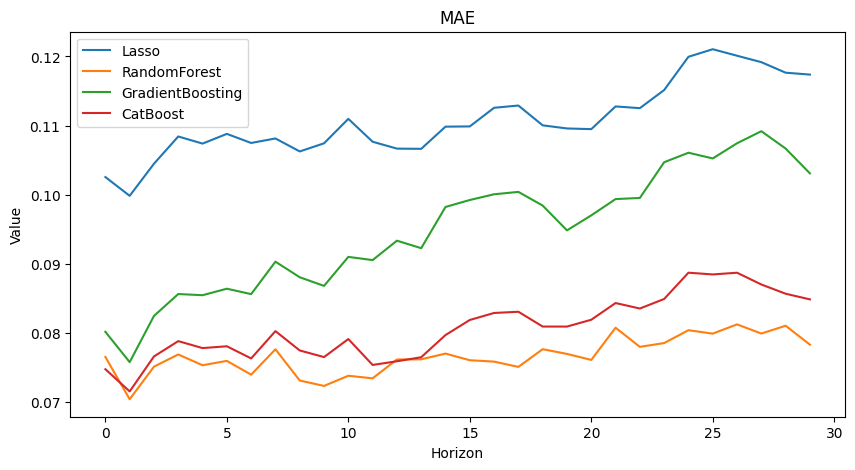

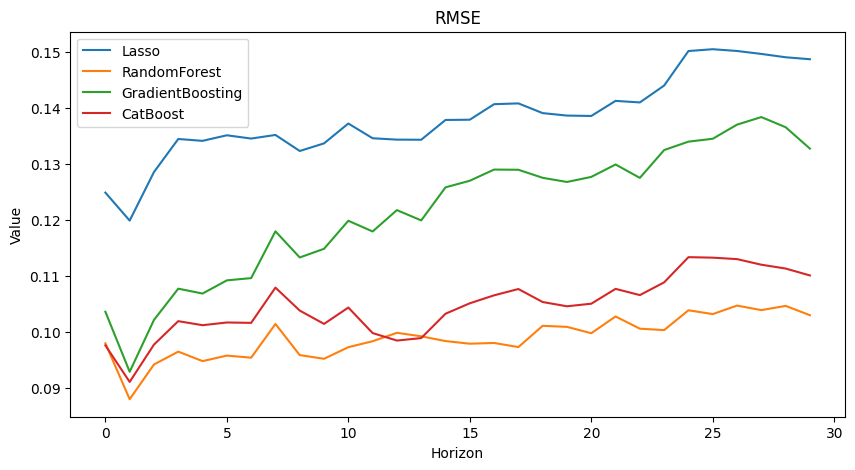

In [64]:
trainer.eval(
    horizons=30
)

In [65]:
trainer.save_results("inc_day")

### Приемки по часам

In [68]:
df = ts_from_csv("incoming.csv", "h")
target_column = "incoming_volume"
df[target_column]/=df[target_column].max()

proc = ForecastPreprocessor(
    lag_config={
        target_column : range(1,24)
    },
    rolling_config={
        target_column : [12,24,48,24*7]
    }
)

trainer = SklearnTrainer(
    df=df,
    target=target_column,
    preprocessor=proc,
    test_size=0.2
)

In [69]:
trainer.optim_model(
    "Lasso",
    Lasso,
    lr_params,
    n_trials=50,
    n_jobs=-1
)

[I 2025-05-21 12:15:25,089] A new study created in memory with name: no-name-3b0c637c-f755-420d-b169-e2e28e9fb5db
[I 2025-05-21 12:15:25,197] Trial 1 finished with value: 0.20700281835934295 and parameters: {'random_state': 42, 'alpha': 0.4636569306240056}. Best is trial 1 with value: 0.20700281835934295.
[I 2025-05-21 12:15:25,215] Trial 0 finished with value: 0.20264012153953362 and parameters: {'random_state': 42, 'alpha': 0.2418730932272442}. Best is trial 0 with value: 0.20264012153953362.
[I 2025-05-21 12:15:25,296] Trial 2 finished with value: 0.20700281835934295 and parameters: {'random_state': 42, 'alpha': 0.8440493196926641}. Best is trial 0 with value: 0.20264012153953362.
[I 2025-05-21 12:15:25,313] Trial 3 finished with value: 0.20700281835934295 and parameters: {'random_state': 42, 'alpha': 0.8149416783367671}. Best is trial 0 with value: 0.20264012153953362.
[I 2025-05-21 12:15:25,396] Trial 4 finished with value: 0.20700281835934295 and parameters: {'random_state': 42, 

Лучшие параметры для Lasso: {'random_state': 42, 'alpha': 0.05029098632617152}
Лучший RMSE: 0.2002


In [70]:
trainer.optim_model(
    "RandomForest",
    RandomForestRegressor,
    rf_params,
    n_trials=50,
    n_jobs=-1
)

[I 2025-05-21 12:25:59,083] A new study created in memory with name: no-name-6f5d7905-23c1-4ed6-bd1e-8be6df11faac
[I 2025-05-21 12:26:39,189] Trial 1 finished with value: 0.14878000672193709 and parameters: {'random_state': 42, 'n_estimators': 191, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.14878000672193709.
[I 2025-05-21 12:27:44,377] Trial 0 finished with value: 0.14836618650635244 and parameters: {'random_state': 42, 'n_estimators': 306, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.14836618650635244.
[I 2025-05-21 12:29:18,279] Trial 2 finished with value: 0.1482922270547315 and parameters: {'random_state': 42, 'n_estimators': 490, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.1482922270547315.
[I 2025-05-21 12:29:50,719] Trial 4 finished with value: 0.14880884420504198 and parameters: {'random_state': 42, 'n_estimators': 77, 'max_de

Лучшие параметры для RandomForest: {'random_state': 42, 'n_estimators': 288, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 9}
Лучший RMSE: 0.1481


In [71]:
trainer.optim_model(
    "GradientBoosting",
    GradientBoostingRegressor,
    gb_params,
    n_trials=30,
    n_jobs=10
)

[I 2025-05-21 13:16:17,062] A new study created in memory with name: no-name-a881161d-3c77-4397-9550-5be83a50c51a
[I 2025-05-21 13:17:45,874] Trial 4 finished with value: 0.17091453366383796 and parameters: {'random_state': 42, 'n_estimators': 120, 'learning_rate': 0.0050632638909681085, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 1, 'subsample': 0.8210874523658506}. Best is trial 4 with value: 0.17091453366383796.
[I 2025-05-21 13:18:19,917] Trial 8 finished with value: 0.14864338249491021 and parameters: {'random_state': 42, 'n_estimators': 126, 'learning_rate': 0.08828029795201879, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 10, 'subsample': 0.8429665141750771}. Best is trial 8 with value: 0.14864338249491021.
[I 2025-05-21 13:18:31,179] Trial 2 finished with value: 0.1525696109173697 and parameters: {'random_state': 42, 'n_estimators': 111, 'learning_rate': 0.09962352390819672, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 8, 'subsample

Лучшие параметры для GradientBoosting: {'random_state': 42, 'n_estimators': 361, 'learning_rate': 0.022581502878324163, 'max_depth': 3, 'min_samples_split': 19, 'min_samples_leaf': 6, 'subsample': 0.8092050742156298}
Лучший RMSE: 0.1466


In [72]:
trainer.optim_model(
    "CatBoost",
    CatBoostRegressor,
    cb_params,
    n_trials=30,
    n_jobs=10
)

Выходные данные были обрезаны до нескольких последних строк (5000).
4:	learn: 0.1809456	total: 56.5ms	remaining: 11.2s
5:	learn: 0.1774977	total: 63.4ms	remaining: 10.5s
6:	learn: 0.1741401	total: 73.3ms	remaining: 10.4s
7:	learn: 0.1710300	total: 86.8ms	remaining: 10.8s
8:	learn: 0.1686320	total: 101ms	remaining: 11.1s
9:	learn: 0.1659939	total: 121ms	remaining: 11.9s
10:	learn: 0.1638632	total: 140ms	remaining: 12.6s
11:	learn: 0.1619395	total: 163ms	remaining: 13.4s
12:	learn: 0.1601056	total: 175ms	remaining: 13.3s
13:	learn: 0.1584317	total: 189ms	remaining: 13.3s
14:	learn: 0.1568098	total: 211ms	remaining: 13.8s
15:	learn: 0.1553508	total: 229ms	remaining: 14.1s
16:	learn: 0.1541965	total: 247ms	remaining: 14.3s
17:	learn: 0.1530206	total: 267ms	remaining: 14.6s
18:	learn: 0.1518968	total: 288ms	remaining: 14.9s
19:	learn: 0.1509549	total: 305ms	remaining: 14.9s
20:	learn: 0.1501662	total: 320ms	remaining: 14.9s
21:	learn: 0.1492054	total: 340ms	remaining: 15.1s
22:	learn: 0.148

[I 2025-05-21 13:44:35,841] A new study created in memory with name: no-name-fea1311c-2962-462b-9c3e-88174bae87d1
[I 2025-05-21 13:44:43,203] Trial 9 finished with value: 0.1487838294370767 and parameters: {'random_seed': 42, 'verbose': False, 'allow_writing_files': False, 'iterations': 92, 'learning_rate': 0.09466844565028396, 'depth': 4, 'min_data_in_leaf': 24, 'l2_leaf_reg': 2.4308239916754837, 'random_strength': 6.907897355276141, 'bagging_temperature': 8.586147480259124, 'border_count': 40, 'subsample': 0.9037601090431618}. Best is trial 9 with value: 0.1487838294370767.
[I 2025-05-21 13:44:47,454] Trial 8 finished with value: 0.1463672189620778 and parameters: {'random_seed': 42, 'verbose': False, 'allow_writing_files': False, 'iterations': 120, 'learning_rate': 0.10533845496215678, 'depth': 6, 'min_data_in_leaf': 30, 'l2_leaf_reg': 5.506401910823842, 'random_strength': 0.3240260773005569, 'bagging_temperature': 3.068318230571714, 'border_count': 42, 'subsample': 0.82734700248746

Лучшие параметры для CatBoost: {'random_seed': 42, 'verbose': False, 'allow_writing_files': False, 'iterations': 120, 'learning_rate': 0.10533845496215678, 'depth': 6, 'min_data_in_leaf': 30, 'l2_leaf_reg': 5.506401910823842, 'random_strength': 0.3240260773005569, 'bagging_temperature': 3.068318230571714, 'border_count': 42, 'subsample': 0.8273470024874691}
Лучший RMSE: 0.1464


In [ ]:
trainer.eval(
    horizons=24*7
)

In [ ]:
trainer.save_results("inc_hour")

### Отгрузки по часам

In [ ]:
df = ts_from_csv("outcoming.csv", "h")
target_column = "outgoing_volume"
df[target_column]/=df[target_column].max()

proc = ForecastPreprocessor(
    lag_config={
        target_column : range(1,24)
    },
    rolling_config={
        target_column : [12,24,48,24*7]
    }
)

trainer = SklearnTrainer(
    df=df,
    target=target_column,
    preprocessor=proc,
    test_size=0.2
)

In [ ]:
trainer.optim_model(
    "Lasso",
    Lasso,
    lr_params,
    n_trials=50,
    n_jobs=-1
)

In [ ]:
trainer.optim_model(
    "RandomForest",
    RandomForestRegressor,
    rf_params,
    n_trials=50,
    n_jobs=-1
)

In [ ]:
trainer.optim_model(
    "GradientBoosting",
    GradientBoostingRegressor,
    gb_params,
    n_trials=30,
    n_jobs=10
)

In [ ]:
trainer.optim_model(
    "CatBoost",
    CatBoostRegressor,
    cb_params,
    n_trials=30,
    n_jobs=10
)

In [ ]:
trainer.eval(
    horizons=24*7
)

In [ ]:
trainer.save_results("out_hour")